# Introduction

The battle with attrition and its implications to productivity and morale is possibly the biggest headache that any manager will have to face. Responses to counteract and to decrease attrition  often require the manager to understand the causes and estimate the costs associated with staff turnover.

In his 2009 paper, Yazinski identified 7 main reasons apart from salary that contribute to employee turnover:
1. Employees feel the job or workplace is not what they expected,
2. There is a mismatch between the job and person,
3. There is too little coaching and feedback,
4. There are too few growth and advancement opportunities,
5. Employees feel devalued and unrecognized,
6. Employees feel stress from overwork and have a work/life imbalance, and
7. There is a loss of trust and confidence in senior leaders

This Kaggle challenge invites us to “Uncover the factors that lead to employee attrition and explore important questions such as ‘show me a breakdown of distance from home by job role and attrition’ or ‘compare average monthly income by education and attrition’. This is a fictional data set created by IBM data scientists.”

This notebook is divided into two parts:
1. The first part will consider the data provided and attempt to identify trends and patterns.
2. The data is then split into training and testing sets and several machine learning techniques are used to  identify the individuals that are more likely to leave the organization.

An attempt is being done to structure this work in functions that can be used in other datasets. A copy of all the code and data used in this project can be found at https://github.com/carmelgafa/ibm-hr-analytics/.

In [22]:
# imports required by this notebook

import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.colors import ListedColormap

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import tree
from sklearn.ensemble import GradientBoostingClassifier
import joblib

# Part 1 - Analysis

We start by taking a high-level look at the data provided. The set contains a ‘Yes/No’ field indicating whether the employee has left the company but we are not given any information about the departure date. 

There are 34 features that describe each employee, his/her role in the company, his/her level of satisfaction, the salary and share options available and his/her influence on the company.

Out of the above, four features are redundant because they either contain no information or they contain information that is not relevant to an employee’s decision to leave the company.



The exercise began with the creation of a 'constants' class that contained important parameters for this project. The names of all the features were abstracted in this class.

In [41]:
class constants():
    """
    Constants required for this excercise
    items postfixed by _T are categorized and will need to be encoded
    items postfixed by _R are redundant
    """

    ISRESIGNED_T = 'Attrition'

    # employee related information
    AGE = 'Age'
    EDUCATION_T = 'EducationField'
    GENDER_T = 'Gender'
    COMPANIES = 'NumCompaniesWorked'
    STATUS_T = 'MaritalStatus'
    HOMEDISTANCE = 'DistanceFromHome'

    # role of the employee in the company
    ROLE_T = 'JobRole'
    LEVEL = 'JobLevel'
    DEPARTMENT_T = 'Department'
    YEARSCOMPANY = 'YearsAtCompany'
    YEARSEMPLOYED = 'TotalWorkingYears'
    YEARSROLE = 'YearsInCurrentRole'
    YEARSLASTPROMO = 'YearsSinceLastPromotion'
    YEARSMANAGER = 'YearsWithCurrManager'

    # satisfaction informaiton
    SATISFACTION = 'JobSatisfaction'
    TEAMCLICK = 'RelationshipSatisfaction'
    LIFEBALANCE = 'WorkLifeBalance'
    ENVIRONMENT = 'EnvironmentSatisfaction'

    # salary and money related
    SALARY = 'MonthlyIncome'
    MONTHLYRATE = 'MonthlyRate'
    DAILYRATE = 'DailyRate'  # Daily rate = the amount of money you are paid per day
    HOURLYRATE = 'HourlyRate'

    # Percent salary hike = the % change in salary from 2016 vs 2015.
    LASTINCREMENTPERCENT = 'PercentSalaryHike'
    STOCKOPTIONS = 'StockOptionLevel' # Stock option level = how much company stocks you own.
    TRAINING = 'TrainingTimesLastYear'

    # rating and involvement related
    RATING = 'PerformanceRating'
    INVOLVEMENT = 'JobInvolvement'
    OVERTIME_T = 'OverTime'  # Y/N
    TRAVEL_T = 'BusinessTravel'  # rare / requent

    # redundant fields
    EMPLYEENO_R = 'EmployeeNumber'  # number
    EMPLOYEECOUNT_R = 'EmployeeCount'  # all 1
    ISOVER18_R = 'Over18'  # all Y
    STDHOURS_R = 'StandardHours'  # all 40
    
    
    # files used in the model creation process
    orig_file = '../data/WA_Fn-UseC_-HR-Employee-Attrition.csv'
    processed_file = 'datasets/HR_attrition_orig_proc.csv'

    train_x_file = 'datasets//HR_attrition_train_x.csv'
    test_x_file = 'datasets/HR_attrition_test_x.csv'
    train_y_file = 'datasets/HR_attrition_train_y.csv'
    test_y_file = 'datasets/HR_attrition_test_y.csv'

    train_x_nb_file = 'datasets/HR_attrition_train_x_nb.csv'
    test_x_nb_file = 'datasets/HR_attrition_test_x_nb.csv'

    train_x_lr_file = 'datasets/HR_attrition_train_x_lr.csv'
    test_x_lr_file = 'datasets/HR_attrition_test_x_lr.csv'
    train_x_nn_file = 'datasets/HR_attrition_train_x_nn.csv'
    test_x_nn_file = 'datasets/HR_attrition_test_x_nn.csv'


A specific method was created to load the data from the csv file that was provided. The method generates two datasets containing:

1. The original data with no modifications whatsoever.
2. A processed version, where specific columns are dropped because they are irrelevant and other columns containing categorical data are encoded into numerical values so that they can be processed by the functions presented later.

Each dataset is stored in two numpy arrays, one contains the dataset header whilst the other contains the dataset data.

The method also generates some analytics information in a dictionary.

In [42]:
def load_data(filename, encode_list, column_drop_list):
    """
    Loads the data from a csv file
    This method will produce two datasets:

    The original data containing the data from the csv file

    A 'massaged data set' that will contain the data after two operaitons take place:
    1. drop of irrelevant columns as defined in the column_drop_list
    2. encoding of labelled values to numeric counterparts as defined in encode_list

    An analytics dictionary is also provided, with shape, description and correlation operaitons performed on the massaged dataset

    Arguments:
    encode_list -- list of the columns to encode to numerical values from the original dataset in the 'massaged dataset'
    column_drop_list -- list of the columns to drop from the original dataset in the 'massaged dataset'

    Returns:
    header orig -- the header row of the file containing the columns titles
    data_orig -- the data rows of the file
    header_massaged -- header row of the massaged dataset
    data_massaged -- data rows of the massaged dataset
    data_analytics -- dictionary of initial analysis of the data:
                            nulls -- flag indicationg theat the dataset conatins nulls
                            shape -- shape structure
                            description -- pandas anlysis
                            correlation -- correlation matrix
    """

    data_df = pd.read_table(filename, sep=',')

    contains_nulls = False
    # check that dataframe does not contain null values
    if data_df.isnull().values.any():
        contains_nulls = True

    header_orig = np.array(data_df.columns.values).squeeze()
    data_orig = np.array(data_df.values)

    # create a clone dataframe that will be 'massaged'
    data_df_copy = data_df.copy(deep=True)

    for encode_item in encode_list:
        data_df_copy[encode_item].replace(data_df_copy[encode_item].unique(), range(
            0, len(data_df_copy[encode_item].unique())), inplace=True)

    for drop_column_item in column_drop_list:
        del data_df_copy[drop_column_item]

    header_massaged = np.array(data_df_copy.columns.values).squeeze()
    data_massaged = np.array(data_df_copy.values)

    data_analytics = {
        'nulls' : contains_nulls,
        'shape': data_df.shape,
        'description': data_df_copy.describe(),
        'correlation': data_df_copy.corr()
    }

    return header_orig, data_orig, header_massaged, data_massaged, data_analytics


It is possible to catty out some initial analysis of this data after loading the data file.

Two functions were created to display the analysis information generated when the load function was executed. The first prints the textual information, whilst the second plots the correlation matrix for the data.

In [43]:
def analyse_data_init(header, analytics):
    """
    Displays initial analysis on a loaded dataset. In particular this funciton;

    1. indicates if null values are present
    2. prints the shape of the dataset
    3. prints the description information for the dataset, for each column
    4. plots the correlation matrix

    Arguments:

    header -- the data header for the loaded set
    analytics -- the analyics dictionary provided by the load_data function
    """

    if(analytics['nulls'] == True):
        print('Dataset contains null values')
    else:
        print('Dataset does not contain null values')

    print('Dataset shape: {}'.format(analytics['shape']))

    print(analytics['description'])

    plot_correlation_matrix(header, analytics['correlation'])


In [44]:
def plot_correlation_matrix(headers, correlations):
    """
    Plots the correlation matrix
    
    Arguments:
    headers -- the headers of the correleation graph
    correlations -- the correlation information
    """
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(correlations)
    fig.colorbar(cax)
    ticks = np.arange(0, len(headers), 1)

    ax.set_xticks(ticks)
    ax.set_yticks(ticks)

    ax.set_xticklabels(headers)
    ax.set_yticklabels(headers)

    for tick in ax.get_xticklabels():
        tick.set_rotation(80)

    plt.show()


The code snippet below executes the load function.

In order to execute the method, as explained above, two arrays are necessary. The first contains the columns that will be removed, and the second contains the columns that will be encoded from the original dataset so that the processed dataset is formed. These arrays used by the load function to create the resulting datasets.

Dataset does not contain null values
Dataset shape: (1470, 35)
               Age    Attrition  BusinessTravel    DailyRate   Department  \
count  1470.000000  1470.000000     1470.000000  1470.000000  1470.000000   
mean     36.923810     0.838776        0.392517   802.485714     0.739456   
std       9.135373     0.367863        0.665455   403.509100     0.527792   
min      18.000000     0.000000        0.000000   102.000000     0.000000   
25%      30.000000     1.000000        0.000000   465.000000     0.000000   
50%      36.000000     1.000000        0.000000   802.000000     1.000000   
75%      43.000000     1.000000        1.000000  1157.000000     1.000000   
max      60.000000     1.000000        2.000000  1499.000000     2.000000   

       DistanceFromHome    Education  EducationField  EnvironmentSatisfaction  \
count       1470.000000  1470.000000     1470.000000              1470.000000   
mean           9.192517     2.912925        1.462585                 2.721769   


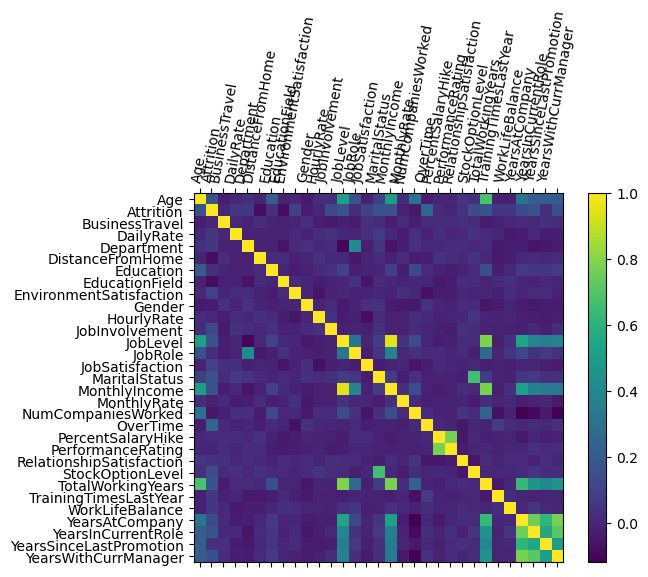

In [45]:
column_drop_list = [constants.EMPLYEENO_R, constants.EMPLOYEECOUNT_R,
                    constants.ISOVER18_R, constants.STDHOURS_R]
encode_list = [constants.GENDER_T, constants.STATUS_T, constants.DEPARTMENT_T, constants.ROLE_T,
               constants.OVERTIME_T, constants.TRAVEL_T, constants.ISRESIGNED_T, constants.EDUCATION_T]

header, data, m_header, m_data, analytics = load_data(
    constants.orig_file, encode_list, column_drop_list)


analyse_data_init(m_header, analytics)

# Initial analysis

 The first step is expected, the data is loaded and examined. 

We are presented with 1470 records of employees, each having 35 pieces of information. Fortunately, the data looks clean, with no missing information.

"How bad is attrition?" We are not presented with temporal data, that is we do not know the date when an employee was employed and when the employee resigned, and therefore we cannot deduce whether the company has gone through a 'rough patch' and consequently there was a resignation spike. Out of our 1470 employees, 237 or 16% have resigned. This might be normal in some industries, yet it should raise an eyebrow at senior management level.

This company consists to 40% female workforce, with most employees living as close as 14 miles to the company’s location. Most employees are satisfied with the work environment and team members. 

A performance rating is given to each employee; however, we notice that all ratings are wither 3 or 4, thus making the efficacy of this measure questionable. In most cases, employees were promoted in the last 4 years.

Most of the features given in this dataset are poorly correlated to each other, with the exception of YearsAtCompany, YearsInCurrentRole, YearsSinceLastPromotion	, YearsWithCurrManager and TotalWorkingYears. We also see that understandably there is a good correlation between PerformanceRating and PercentSalaryHike; and between MonthlyIncome and JobLevel.

To dive a little deeper in the information, the features described by categorical data were then examined, and the attrition rate for these features analysed. In order to achieve this, two functions were created; a first function that drills into the data by and works out the attrition per category of each feature, and a second that plots the numbers of employees (remaining and left) in a bar chart and superimposes the attrition measurement for these categories.

In [46]:
def analyse_attrition(header, data, features_to_analyse, attrition_true, attrition_false):
    """
    In oder to print graphs tiled, create a figure at the beginng of the script and
    use the correct position when calling plot_attrition_curve; (e.g. 311, 312 313).
    Then call the plt.show at the end of the script.

    For seperate plots, create a figure for each plot, call plot_attrition_curve with
    position 111 and plt.show for each plot.

    Arguments:
    header -- the data header
    data -- the data
    """
    for feature in features_to_analyse:
        fig = plt.figure()
        results = analysis_attrition_feature(
            header, data, feature, constants.ISRESIGNED_T, attrition_true, attrition_false)
        plot_attrition_curve(results, feature, fig, 111)
        plt.show()


In [47]:
def analysis_attrition_feature(header, data, feature_id, attrition_feature_id,
                               attrition_true=1, attrition_false=0):
    """
    Analyses the attrition of a specified feature. For example if the feature
    is teh departments this fucntion will give the number of employees,
    number of terminations and attrition per department

    Arguments:
    header -- the header infomation of this dataset
    data -- the dato to process
    feature_id -- the column name of the feature to examine (e.g. Departments)
    left_feature_id -- the column name of the attrition column
    left_true -- the value of the left column when the employee has left
    left_false -- the value of the left column when the employee is still employed

    Returns:
    results -- hashmap of results having:
                Categories, array of categories of theis feature
                Current, array of current employees for each feature
                Left, array of left employees for each feature
                Attrition, array for the attrition for each feature
    """
    results = {}

    # the index in the data that points to the attrition
    left_idx = np.argwhere(header == attrition_feature_id).squeeze()

    # the index in the data that points to the department of the employee
    feature_idx = np.argwhere(header == feature_id).squeeze()

    # the names of the categories in this feature
    # e.g. all teh department names under the header departments
    categories = np.unique(data[:, np.argwhere(header == feature_id)])

    category_employees_current = np.empty((len(categories), 0), dtype=int)
    category_employees_left = np.empty((len(categories), 0), dtype=int)

    for category in categories:
        # filter the data for the feature
        feature_data = data[np.where(
            data[:, feature_idx] == category), :].squeeze()

        # extract emplyees still employed and add their count to the current employees array
        still_working = len(
            np.where(feature_data[:, left_idx] == attrition_false)[0])

        category_employees_current = np.append(
            category_employees_current, [still_working])

        # extract emplyees that left and add their count to the left employees array
        left = len(np.where(feature_data[:, left_idx] == attrition_true)[0])
        category_employees_left = np.append(category_employees_left, [left])
        #print('{} -{}'.format(feature, feature_employees_left.shape))

    feature_percentage_attrition = category_employees_left / (category_employees_current
                                                              + category_employees_left) * 100

    # move all results in hashmap
    results['categories'] = categories
    results['current'] = category_employees_current
    results['left'] = category_employees_left
    results['attrition'] = feature_percentage_attrition

    return results


In [48]:
def plot_attrition_curve(results, title, fig, position):
    """
    Plots the the number of employees employed vs the number of employees left
    of all the various categories for a given feature.
    For example if we cansider the departments feature, this function will plot a 
    bar graph of the current and resigned employees for eveery department.
    It will also superimpose the attrition values for each category

    Arguments:
    results -- dictionary containing all the data necessary
                'Features'
    """
    plt.gcf().subplots_adjust(bottom=0.4)

    categories = results['categories']
    employees_current = results['current']
    employees_left = results['left']
    percentage_attrition = results['attrition']

    X = range(0, len(categories), 1)

    ax1 = fig.add_subplot(position)
    fig.suptitle(title)

    ax1.bar(X, employees_current, color='b', alpha=0.5)
    ax1.bar(X, employees_left, color='r', alpha=0.5, bottom=employees_current)
    ax1.set_ylabel('Employees current & left')

    ax2 = ax1.twinx()
    ax2.plot(X, percentage_attrition, color='b')
    ax2.set_ylim([0, np.max(percentage_attrition)+1])
    ax2.set_ylabel('% Attrition')

    ax2.set_xticks(X)
    ax2.set_xticklabels(categories)

    for tick in ax1.get_xticklabels():
        tick.set_rotation(80)


In order to execute this analysis step, a list of the features to be analysed is necessary. The list is used to generate the relevant plots.

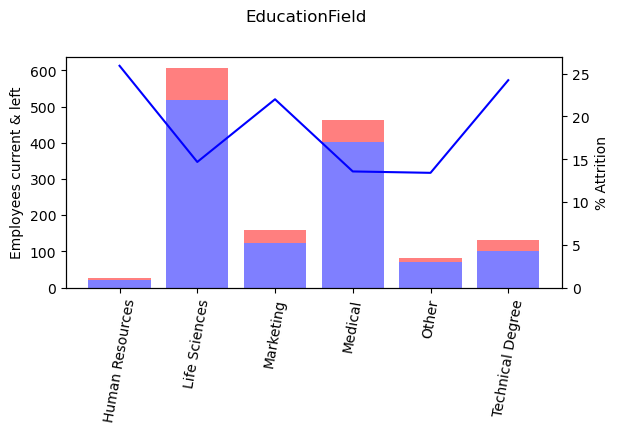

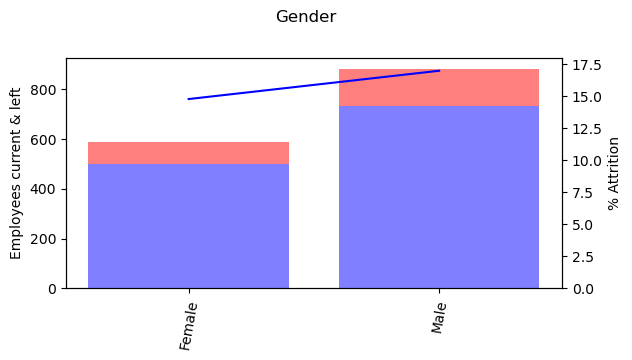

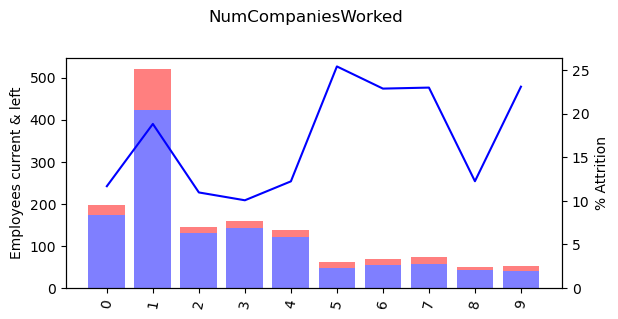

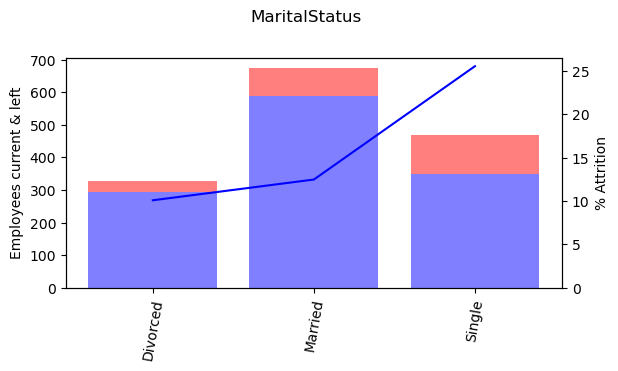

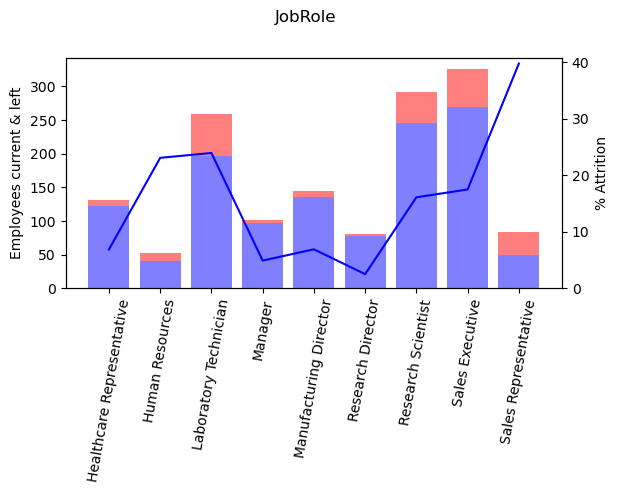

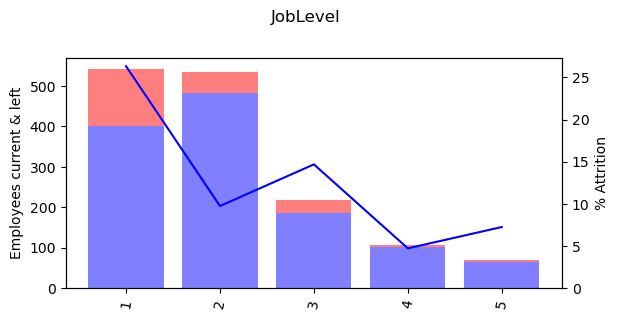

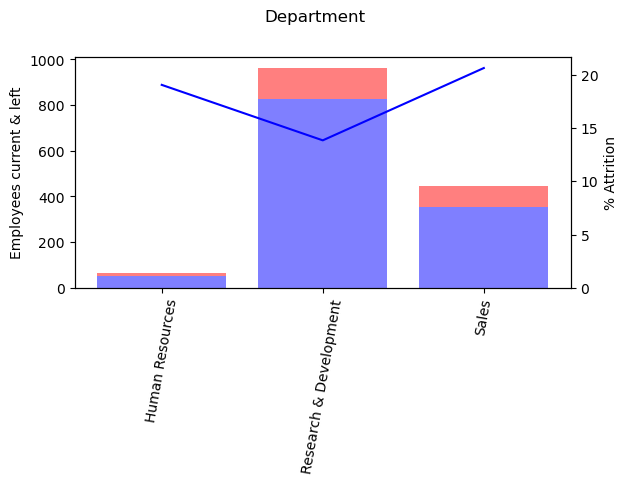

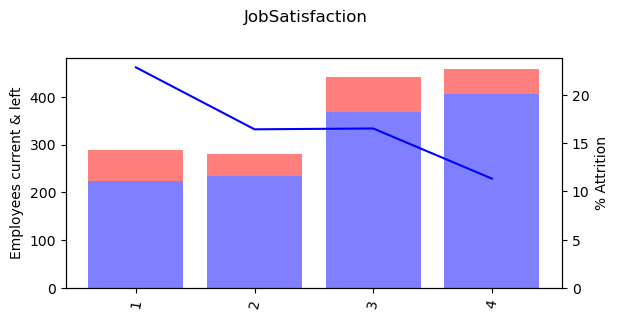

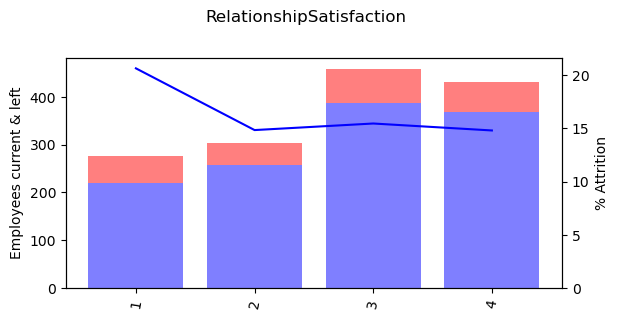

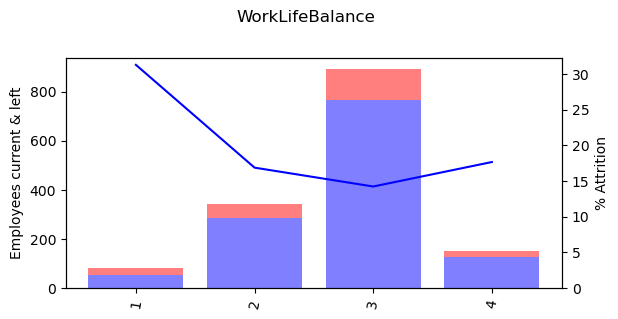

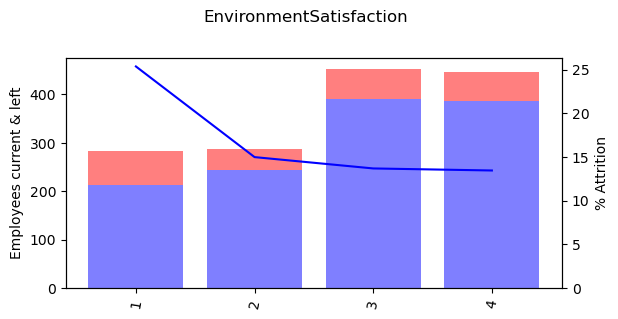

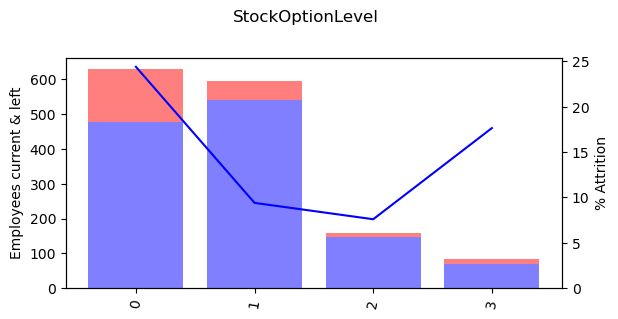

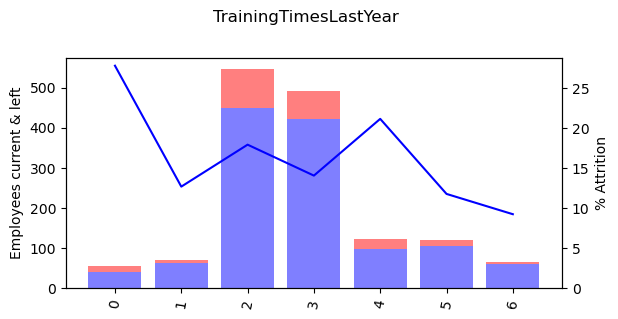

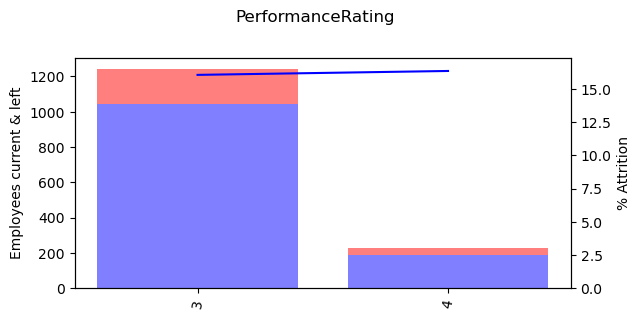

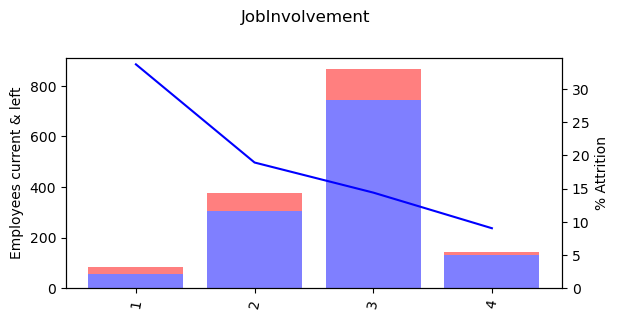

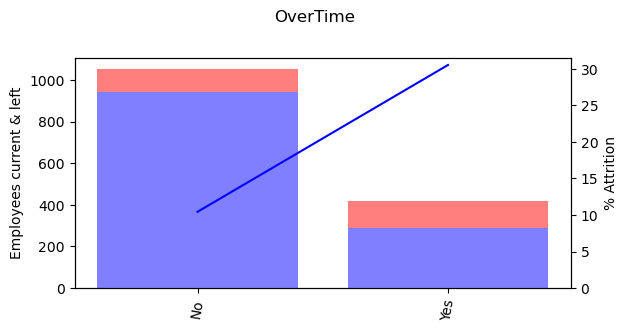

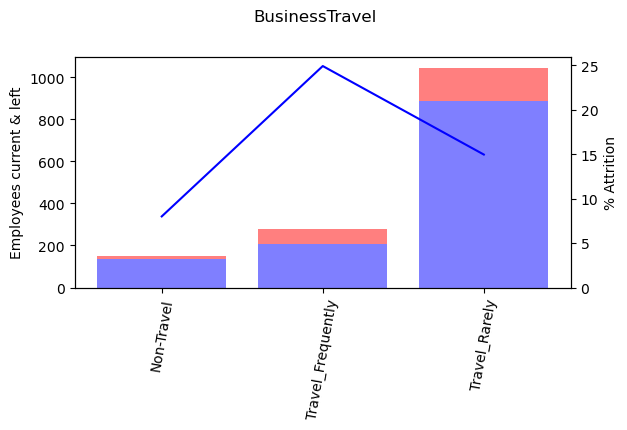

In [49]:
features_to_analyse = [
    constants.EDUCATION_T, constants.GENDER_T,
    constants.COMPANIES, constants.STATUS_T,
    constants.ROLE_T, constants.LEVEL,
    constants.DEPARTMENT_T,
    constants.SATISFACTION, constants.TEAMCLICK,
    constants.LIFEBALANCE, constants.ENVIRONMENT,
    constants.STOCKOPTIONS, constants.TRAINING,
    constants.RATING,
    constants.INVOLVEMENT, constants.OVERTIME_T, constants.TRAVEL_T
]

analyse_attrition(header, data, features_to_analyse, 'Yes', 'No')

# Observations

The following list highlights the main thoughts that emerged from this analysis:
1.	Employees that studied in HR, Marketing and Technical had a higher attrition rate than all the others.
2.	Sales representatives had a tremendously high attrition rate, whilst managers, directors and people in the more senior roles tended to remain in the company’s workforce.
3.	Attrition was slightly higher for males.
4.	A ‘sweet spot’ for employees that were in their third fourth or fifth job was noticed. The attrition rate in these cases was remarkably low.
5.	Singles were more likely to leave the company than divorced and married employees.
6.	Attrition was slightly less in the R&D department when compared to the sales and HR departments.
7.	Employees that were not satisfied in the company, that were very unhappy in their team, that did not have a healthy work life balance, and that were not happy with their work environment were more likely to leave. In all cases we noticed that the attrition rate for ‘very unhappy’ employees was around double than for the other cases.
8.	There was a preferred stock option scheme, the option number 3. The attrition rate for this scheme was much lower than for the other three.
9.	Training was also a very important factor. We noticed that the attrition rate for the employees that received no training was around 25%, compared to values that range from 10% to 15% for employees that did receive some training.
10.	The performance rating had no effect on attrition. As we noticed before, all employees were graded as either 3 or 4. In this analysis we noticed that turnover was practically the same in both cases. In addition, we noticed that a only a small percentage (12%) of the total workforce were rated a grade 4.
11.	Employees that were not involved in their work tended to leave.
12.	Overtime had a negative effect on attrition. We noticed that employees were more likely to leave when they did overtime. 
13.	A similar situation was encountered when travel was considered. Employees that travelled frequently were more likely to leave.

# Further Analysis

In the above exercise the categorical data in the set was analysed with regards to attrition level. 
In the following, the same attempt was being carried out on the real-valued data in the set. As in the first case, two functions were developed; the first function selects and formats the data, whilst the second plots it in a scatter plot.

In [50]:
def analysis_comparison_features(header, data, x_feature_id, y_feature_id, z_feature_id, filter_feature_id=None, filter_feature_value=None):
    """
    """
    # the index of the number of years at the company
    x_feature_idx = np.argwhere(header == x_feature_id).squeeze()

    # the index of the salary at the company
    y_feature_idx = np.argwhere(header == y_feature_id).squeeze()

    # the index of the salary at the company
    z_feature_idx = np.argwhere(header == z_feature_id).squeeze()

    if filter_feature_id != None:
        filter_feature_idx = np.argwhere(header == filter_feature_id)
        filtered_data = data[np.where(
            data[:, filter_feature_idx] == filter_feature_value), :]
    else:
        filtered_data = data

    x_data = filtered_data[:, x_feature_idx]
    y_data = filtered_data[:, y_feature_idx]
    z_data = filtered_data[:, z_feature_idx]

    return x_data, y_data, z_data


In [51]:
def plot_comparison_curve(x_title, y_title, x_data, y_data, z_data):

    left_color = 'lightcoral'
    remained_color = 'green'

    z_left = np.where(z_data == 0)
    z_remained = np.where(z_data == 1)

    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    bottom_h = left_h = left + width + 0.02

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.2]
    rect_histy = [left_h, bottom, 0.2, height]

    plt.figure(1, figsize=(8, 8))
    axScatter = plt.axes(rect_scatter)
    axHistx = plt.axes(rect_histx)
    axHisty = plt.axes(rect_histy)

    colors = [left_color, remained_color]

    axScatter.set_xlabel(x_title)
    axScatter.set_ylabel(y_title)

    axScatter.scatter(x_data, y_data, c=z_data, cmap=ListedColormap(colors), alpha=0.5)

    x_bins = min(30, len(np.unique(x_data)))

    axHistx.hist(x_data[z_left], bins=x_bins, color=left_color, alpha=0.5)
    axHistx.hist(x_data[z_remained], bins=x_bins, color=remained_color, alpha=0.5)

    x_left_hist = np.histogram(x_data[z_left], bins=x_bins)[0]
    x_remained_hist = np.histogram(x_data[z_remained], bins=x_bins)[0]
    # added a small factor to avoid division errors
    attrition = x_left_hist / (x_remained_hist + x_left_hist + 0.00005) * 100

    axHistx_2 = axHistx.twinx()
    axHistx_2.plot(np.histogram(x_data[z_left], bins=x_bins-1)[1], attrition, color='b')
    axHistx_2.set_ylim([0, 105])
    axHistx_2.set_ylabel('% Attrition')

    y_bins = min(30, len(np.unique(y_data)))

    axHisty.hist(y_data[z_left], bins=y_bins, color=left_color,
                 alpha=0.5, orientation='horizontal')
    axHisty.hist(y_data[z_remained], bins=y_bins, color=remained_color,
                 alpha=0.5, orientation='horizontal')

    plt.show()


In [52]:
def analyse_comparison(header, data, comparison_sets):
    for feature_1, feature_2 in comparison_sets:
        x, y, z = analysis_comparison_features(
            header, data, feature_1, feature_2, constants.ISRESIGNED_T)
        plot_comparison_curve(feature_1, feature_2, x, y, z)


The execution of this analysis step is very similar to the execution of the first step. A list that contained the featured to be analysed was created and then it was used to create the plots.

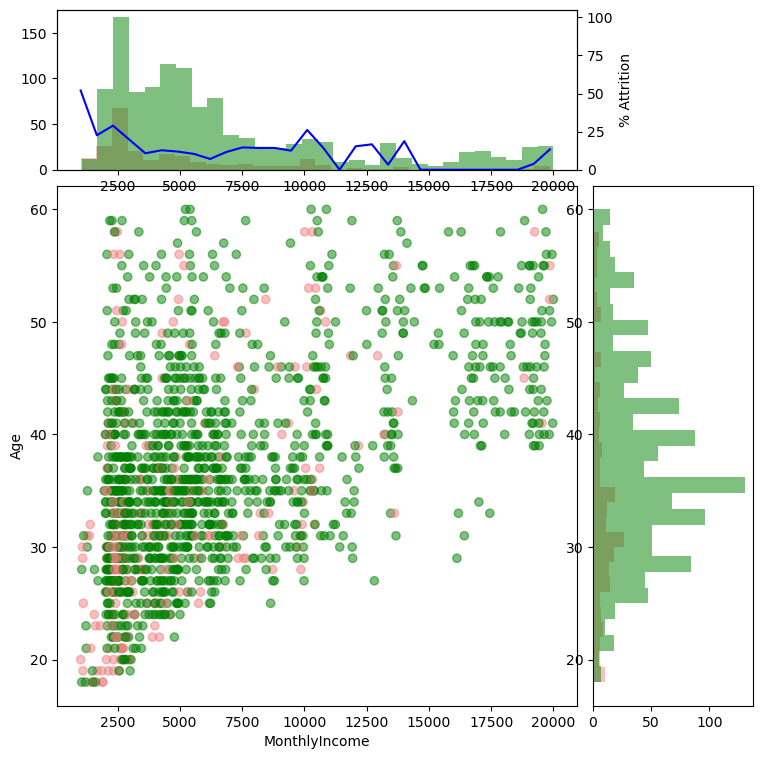

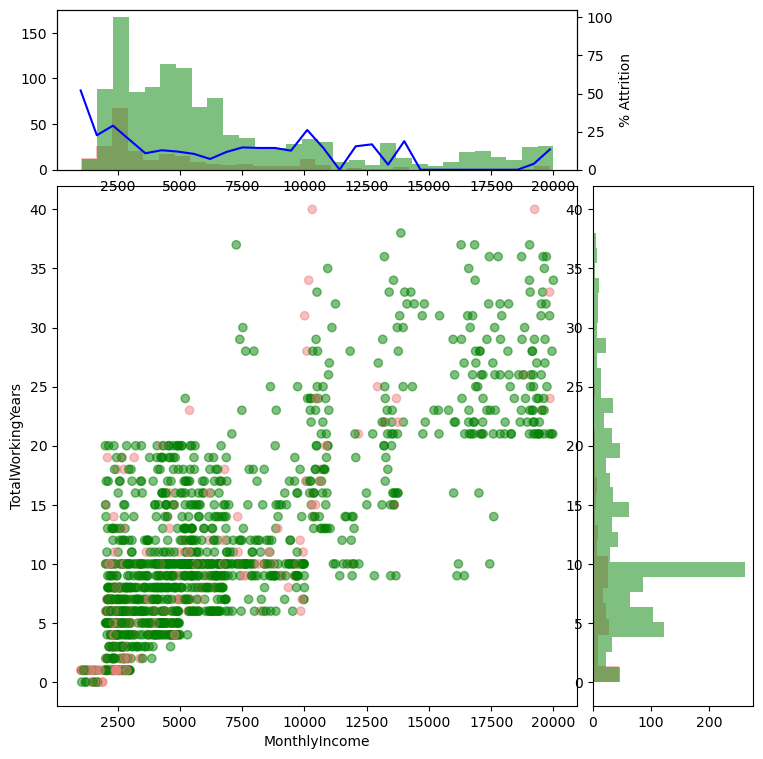

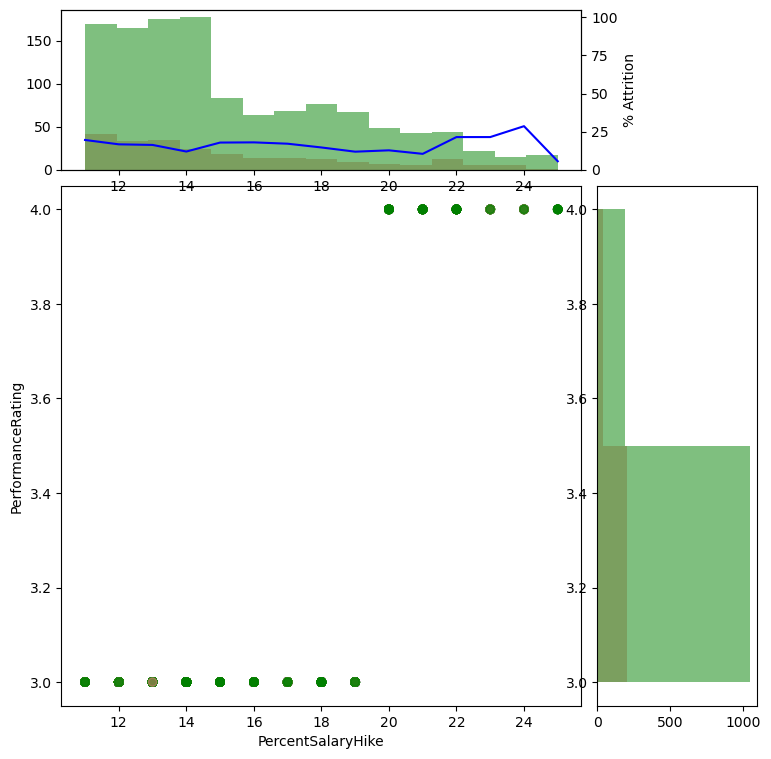

In [53]:
comparison_sets = [(constants.SALARY, constants.AGE),
                    (constants.SALARY, constants.YEARSEMPLOYED),
                    (constants.LASTINCREMENTPERCENT, constants.RATING)]

analyse_comparison(m_header, m_data, comparison_sets)

# Observations

Three plots were generated from this analysis step. It was noticed that salary was a major trigger to leave the company, especially for young employees; as the attrition rate was nearly 50 % for employees who were less than thirty years old and that has their salary in the lowest band.
It was also noticed that there was some relation between the salary and number of years in the company, and somewhat, either by natural progression in the company’s ranks or by turnover there were no employees with a seniority of over 20 years in the lowest salary bands.
Finally, an increment structure was deduced when the salary increments were examined with the employees’ grade. There was a clear discrimination between 3 and 4 performers, where the 4 performers received an increment that had a maximum value of 25% (there were 18 such instances), whilst and the lowest increment for a 3 performer was 11% (210 cases).

# Part 2 - Machine Learning Models

Numerous other studies that could have been carried out on this data. But having gained some insight on the characteristics of this company, an attempt to build some models was then carried out.
The results of several classification models, namely:
1.	Naïve Bayes
2.	Logistic Regression
3.	K-Nearest Neighbours
4.	Neural Network
were then compared.

The procedure adopted to engineer the data so that these models could be executed is illustrated in the diagram below:

![](https://storage.googleapis.com/kagglesdsdata/datasets/16151/21316/HR%20ML.jpg?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1521191545&Signature=PwjVhdwuNsnLV53eGWLG9aIlvD5kTkcoSlPhzOQmh5tmpsqgeC7WSq5IkpBsLn5P3qzrN4h6dqBkIb99fk%2FsIJCtbZmlUOletjGvBNWYAJ%2FESOv%2FPIjOjJ5HtxdmFluzZLI%2BD2PZtMyyJbysTgXGbPmYyFffacN%2F19t5%2FUavG4iP4EanjB6iA9TG0tnV3nk708NZ5n4nf7oHEey5BJ6c9Gv21cvjmpmKNTVMSdekuKDlLvIJyde%2Fw81E2Op9WGcNke%2BOX%2F%2FxmoktT1eUdXx54HiXyMtrevncIcezhHBi8%2BiSM1PPhOBkFDbNbKz4XFScbYzINJHvee5uItVHNHx4ow%3D%3D)


As a first step, the data is ‘cleaned’ from redundant information and the categorical text fields are coded in a numerical equivalent as explained earlier on in this notebook. The result of this step is saved in a file.
The data is the split in train and test sets, where an 80/20 split was applied. The output feature, or the ‘Attrition’ field was also extracted and saved in another file, so that an X and Y files were created for both training and testing sets.

This data was then further processed to create the data required for each specific model. For example, in the Naïve Bayes case, the continuous fields were discretized using a number of buckets. Similarly, in the Neural Networks case, the continuous data was standardized and the categorical data was encoded using dummy coding.

In all cases the resulting data-sets were stored in files.


# Helper Scripts

Several  functions were used to create the model data set files. They were not executed in this notebook as Kaggle had some limitations when new data files were created. However, they are included below for completeness sake.

In [54]:
def save_data(filename, header, data, override=False):
    """
    saves a dataset to file

    Arguments:
    filename -- the name of the dataset file
    header -- the data header
    data -- the data information

    Returns:
    """

    script_dir = os.path.dirname(__file__)
    abs_data_file_path = os.path.join(script_dir, filename)

    if (os.path.exists(abs_data_file_path) is False) or (override is True):
        # create dataframe with right format
        data_frame = pd.DataFrame(data=data, columns=header)
        # save data, remove index coluum
        data_frame.to_csv(abs_data_file_path, index=False)

In [55]:
def partition_data(data_orig, train_percentage=0.6, test_percentage=0.2):
    """
    Divides a dataset in three parts after randomly rearranging its rows. Default partitions
    are as follows:
    Training set -- 60% of data
    Testing set -- 20% of data
    Dev Set -- 20% of data

    Arguments:
    data_orig -- the original, complete dataset
    train_percentage -- the percentage of the dataset that will become training data
    test_percenntage -- the percentage of the dataset that will become testing data
                        hence the development dataset will become the remainder
    Returns:
    train_set -- the training data set
    test_set -- the testing data set
    dev_set -- the development data set
    """
    # shuffle data. as data is shuffled accross rows, it requires the double transpose
    np.random.shuffle(data_orig)
    data_orig = data_orig

    train_set_size = (int)(data_orig.shape[0] * train_percentage)
    test_set_size = (int)(data_orig.shape[0] * test_percentage)

    train_set = data_orig[:train_set_size, :]
    test_set = data_orig[train_set_size:train_set_size+test_set_size, :]
    dev_set = data_orig[train_set_size+test_set_size:, :]

    return train_set, test_set, dev_set


In [56]:
def prepare_model_data(rewrite_files=False):
    '''
    Prepares the data set files used by the models.

    Returns:
    results -- dictionary containing the following
        train_x_nb -- training x for naive bayes data set
        train_y -- training y data set
        test_x_nb -- test x for naive bayes data set
        test_y -- test y data set
        train_x_nn -- training x for neural nets (& Logistic regression)  data set
        test_x_nn -- test x for neural nets (& Logistic regression)  data set
    '''

    # step 1:
    column_drop_list = [constants.EMPLYEENO_R, constants.EMPLOYEECOUNT_R,
                        constants.ISOVER18_R, constants.STDHOURS_R]
    encode_list = [constants.GENDER_T, constants.STATUS_T, constants.DEPARTMENT_T, constants.ROLE_T,
                   constants.OVERTIME_T, constants.TRAVEL_T, constants.ISRESIGNED_T, constants.EDUCATION_T]

    _, _, m_header, m_data, _ = load_data(
        constants.orig_file, encode_list, column_drop_list)

    save_data(constants.processed_file, m_header, m_data, override=rewrite_files)

    # step 2:
    train_data, test_data, _ = partition_data(m_data, 0.8, 0.2)

    output_idx = np.argwhere(m_header == constants.ISRESIGNED_T).squeeze()

    train_y = train_data[:, output_idx]
    train_x = np.delete(train_data, output_idx, 1)

    test_y = test_data[:, output_idx]
    test_x = np.delete(test_data, output_idx, 1)

    traintest_header = np.delete(m_header, output_idx, 0)

    save_data(constants.train_x_file, traintest_header, train_x, override=rewrite_files)
    save_data(constants.train_y_file, np.array([constants.ISRESIGNED_T]), train_y, override=rewrite_files)
    save_data(constants.test_x_file, traintest_header, test_x, override=rewrite_files)
    save_data(constants.test_y_file, np.array([constants.ISRESIGNED_T]), test_y, override=rewrite_files)

    # to execute naive bayes we will discretise continuous data
    column_bins_definition = {constants.AGE: 10, constants.DAILYRATE: 10,
                              constants.HOMEDISTANCE: 10, constants.SALARY: 10,
                              constants.HOURLYRATE: 10, constants.MONTHLYRATE: 10,
                              constants.YEARSEMPLOYED: 5, constants.YEARSCOMPANY: 5,
                              constants.YEARSROLE: 5, constants.YEARSLASTPROMO: 5,
                              constants.YEARSMANAGER: 5, constants.LASTINCREMENTPERCENT: 16}

    train_x_nb = digitize_columns(
        traintest_header, train_x, column_bins_definition)
    test_x_nb = digitize_columns(
        traintest_header, test_x, column_bins_definition)

    save_data(constants.train_x_nb_file, traintest_header, train_x_nb, override=rewrite_files)
    save_data(constants.test_x_nb_file, traintest_header, test_x_nb, override=rewrite_files)

    columns_norm = [constants.AGE, constants.DAILYRATE,
                    constants.HOMEDISTANCE, constants.SALARY,
                    constants.HOURLYRATE, constants.MONTHLYRATE,
                    constants.YEARSEMPLOYED, constants.YEARSCOMPANY,
                    constants.YEARSROLE, constants.YEARSLASTPROMO,
                    constants.YEARSMANAGER, constants.LASTINCREMENTPERCENT]

    train_x_lr = feature_scale_columns(traintest_header, train_x, columns_norm)
    test_x_lr = feature_scale_columns(traintest_header, test_x, columns_norm)

    save_data(constants.train_x_lr_file, traintest_header, train_x_lr, override=rewrite_files)
    save_data(constants.test_x_lr_file, traintest_header, test_x_lr, override=rewrite_files)

    encode_list_nn = [constants.GENDER_T, constants.STATUS_T, constants.DEPARTMENT_T, constants.ROLE_T,
                      constants.OVERTIME_T, constants.TRAVEL_T, constants.EDUCATION_T,
                      constants.ENVIRONMENT, constants.INVOLVEMENT, constants.LEVEL,
                      constants.SATISFACTION, constants.COMPANIES, constants.RATING, constants.TEAMCLICK,
                      constants.STOCKOPTIONS, constants.TRAINING, constants.LIFEBALANCE]

    train_test_header_nn, train_x_nn = encode_columns_nn(
        traintest_header, train_x_lr, encode_list_nn)
    _, test_x_nn = encode_columns_nn(
        traintest_header, test_x_lr, encode_list_nn)

    save_data(constants.train_x_nn_file, train_test_header_nn, train_x_nn, override=rewrite_files)
    save_data(constants.test_x_nn_file, train_test_header_nn, test_x_nn, override=rewrite_files)

    results = {}

    results['train_x_nb'] = train_x_nb
    results['train_y'] = train_y
    results['test_x_nb'] = test_x_nb
    results['test_y'] = test_y
    results['train_x_nn'] = train_x_nn
    results['test_x_nn'] = test_x_nn
    return results

In the next function, data-sets that were required by the machine learning models were loaded from the files and returned in a dictionary.


In [57]:
def load_model_data():
    '''
    Loads the model datasets from the respective files

    Returns:
    results -- dictionary containing the following
        train_x_nb -- training x for naive bayes data set
        train_y -- training y data set
        test_x_nb -- test x for naive bayes data set
        test_y -- test y data set
        train_x_nn -- training x for neural nets (& Logistic regression)  data set
        test_x_nn -- test x for neural nets (& Logistic regression)  data set
    '''
    _, train_x_nb, _, _, _ = load_data(constants.train_x_nb_file,[],[])
    _, train_y, _, _, _  = load_data(constants.train_y_file,[],[])
    _, test_x_nb, _, _, _ = load_data(constants.test_x_nb_file,[],[])
    _, test_y, _, _, _ = load_data(constants.test_y_file,[],[])
    _, train_x_nn, _, _, _ = load_data(constants.train_x_nn_file,[],[])
    _, test_x_nn, _, _, _ = load_data(constants.test_x_nn_file,[],[])

    results = {}
    results['train_x_nb'] = train_x_nb
    results['train_y'] = train_y
    results['test_x_nb'] = test_x_nb
    results['test_y'] = test_y
    results['train_x_nn'] = train_x_nn
    results['test_x_nn'] = test_x_nn

    return results

In [58]:
model_data = load_model_data()

And finally, the models were executed. An execution function was created for this purpose. The models were used using the scikit library, although other libraries such as tensorflow could have been used.

In [59]:
def execute_classifier(classifier_name, classifier, train_x, train_y, test_x, test_y):
    '''
    Executes a classifier given the test and train data. Calculates the execution time for the 
    training

    Arguments:
    classifier_name -- the name of the classifier, for printing purposes
    classifier -- the actual classifier
    train_x -- training x data
    train_y -- training y data
    test_x -- testing x data
    test_y -- testing y data

    Returns:
    prints the result of the training and testing, together with the traioning execution time required
    test-score -- the testing score for this classifier
    '''
    t_start = time.clock()
    classifier.fit(train_x, train_y.ravel())
    t_end = time.clock()
    time_diff = t_end - t_start

    train_score = classifier.score(train_x, train_y)
    test_score = classifier.score(test_x, test_y)

    print('{} -  \t train score: {},\t test score: {},\t time:{}'.format(
        classifier_name, train_score, test_score, time_diff))

    return test_score


In [61]:
# KNN
classifier = KNeighborsClassifier(n_neighbors=3)
test_score = execute_classifier("K - N N", classifier, model_data['train_x_nb'], model_data['train_y'], model_data['test_x_nb'], model_data['test_y'])

AttributeError: module 'time' has no attribute 'clock'

In [ ]:
# naive bayes
classifier = MultinomialNB(alpha=1)
test_score = execute_classifier("Naive Bayes", classifier, model_data['train_x_nb'], model_data['train_y'], model_data['test_x_nb'], model_data['test_y'])

In [ ]:
# logistic regression
classifier = LogisticRegression()
test_score = execute_classifier("Log Reg", classifier, model_data['train_x_nn'], model_data['train_y'], model_data['test_x_nn'], model_data['test_y'])

In [ ]:
# neural net
classifier = MLPClassifier(activation='relu', solver='adam', hidden_layer_sizes=(256,64), max_iter=300)
test_score = execute_classifier("N Net", classifier, model_data['train_x_nn'], model_data['train_y'], model_data['test_x_nn'], model_data['test_y'])

# Conclusion

In this first attempt to address the attrition issue in this company the data provided was analysed and a simple system where data was engineered and transferred into machine learning models that predicted employee attrition was developed. Four machine learning models were implemented in this release, resulting in a best prediction of 90%. It can be observed that a decent result was produced by the neural network, when considering the small amount of data that was provided. We can also deduce that the neural network model is most probably overfitted and therefore some further adjustments are necessary. Several hyperparameter configurations were attempted for this classifier and the best results were included in this notebook.

There is obviously room for further analysis and improvement and tuning of the models. In addition, more classifiers and different architectures can be tested in future attempts.